# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('arrayfire')
yp.config.setDefaultDatatype('float32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Output Path

In [3]:
output_path = os.path.expanduser('~/datasets/motiondeblur/beads_output')
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data

In [4]:

# 4.9um beads, mid brightness
# dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_raster_45ms_coded_raster_100_motion_deblur_2019_02_04_16_34_43'
dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_raster_45ms_strobe_raster_1_motion_deblur_2019_02_04_16_36_13/'
# dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_raster_45ms_


# Create dataset object (loads metadata)
dataset = Dataset(dataset_full_path, use_median_filter=False, subtract_mean_dark_current=False, force_type='motion_deblur')

Loading 1 frames...


## Perform Registration and Normalization

In [5]:
force = False

# Perform registration
dataset.motiondeblur.register(force=force)

# Perform normalization
dataset.motiondeblur.normalize(force=force)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1.0}}

Loading 18 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...
Loading 19 frames...


## Solve For Single Segment

In [9]:
dataset.motiondeblur.position_segment_indicies = [0]
dataset.frame_mask = dataset.frame_mask[:18] # First 18 frames

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, normalize=False, use_psf=False, estimate_background_poly=True)

# Perform reconstruction
recon.reconstruct(iteration_count=-1, step_size=1, frame_number=4, mode='global', reg_types={})

# Save result
recon.save(output_path, filename=recon.dataset.metadata.file_header + 'strip_%d' % dataset.motiondeblur.position_segment_indicies[0], formats=['tiff'], save_raw=False, downsample=None)

Saved .npz file to /Users/zfphil/datasets/motiondeblur/beads_output/beads2_raster_45ms_strobe_raster_1_motion_deblur_2019_02_04_16_36_13strip_0_regularize=[].npz


/Users/zfphil/.conda/lib/python3.7/site-packages/scikit_image-0.14.1-py3.7-macosx-10.7-x86_64.egg/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/zfphil/.conda/lib/python3.7/site-packages/scikit_image-0.14.1-py3.7-macosx-10.7-x86_64.egg/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


KeyboardInterrupt: 

Saved .npz file to /Users/zfphil/datasets/motiondeblur/beads_output/beads2_raster_45ms_strobe_raster_1_motion_deblur_2019_02_04_16_36_13strip_0_regularize=[].npz


<IPython.core.display.Javascript object>


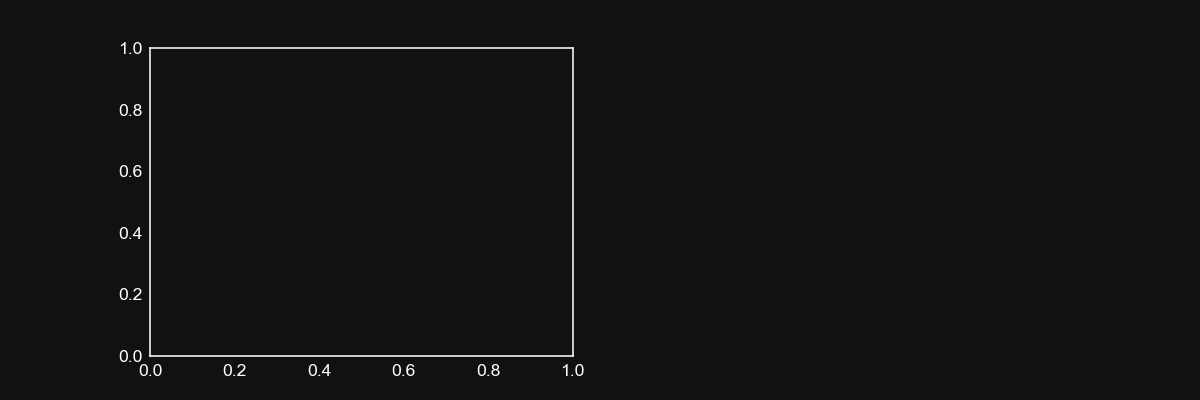

NameError: name 'q' is not defined

In [10]:


plt.figure()
plt.subplot(121)
plt.imshow(q)
# plt.title(str(yp.sum(yp.abs(q) ** 2)))
plt.title(str(yp.mean(q)))
clim = plt.clim()
plt.subplot(122)
plt.imshow(yp.fft.interpolate(q, 4))
# plt.title(str(yp.sum(yp.abs(yp.fft.interpolate(q, 4)) ** 2)))
plt.title(str(yp.mean(yp.fft.interpolate(q, 4))))
plt.clim(clim)

In [ ]:
        # Apply interpolation to y
        if self.interpolation_factor != 1.0:
            interpolated_shape = [yp.next_fast_even_number(int(np.round(self.interpolation_factor * sh_y))) for sh_y in yp.shape(self.y)]
            y_padded = yp.pad(self.y, [yp.next_fast_even_number(sh) for sh in yp.shape(self.y)], center=True)
            self.y = yp.real(yp.iFt(yp.pad(yp.Ft(self.y), interpolated_shape, center=True)))

In [ ]:
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_no_median', formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
plt.clim(0,40)

## Loop Over Segments

In [ ]:
for segment_index in dataset.motiondeblur.position_segment_indicies_full:
    # Set segment index
    dataset.motiondeblur.position_segment_indicies = [segment_index]
    
    # Create recon object
    recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode='mean', )

    # Perform reconstruction
#     recon.reconstruct(iteration_count=-1, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})
    recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})

    # Save result
    recon.save(output_path, filename=recon.dataset.metadata.file_header, formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
# Try with L1 Sparsity